In [1]:
# cell 1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Download NLTK resources if needed
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adnanaltimeemy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adnanaltimeemy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# cell 2
num_records = 10000

# Time range: last 6 years, daily entries; we'll sample random dates
date_start = pd.to_datetime('2018-01-01')
date_end = pd.to_datetime('2024-12-31')
all_days = (date_end - date_start).days

dates = date_start + pd.to_timedelta(
    np.random.randint(0, all_days, size=num_records), unit='D'
)

# Demographics: Teens, Young adults, Middle-aged, Seniors
demo_categories = ['Teens', 'Young adults', 'Middle-aged', 'Seniors']
demographics = np.random.choice(
    demo_categories,
    size=num_records,
    p=[0.2, 0.4, 0.3, 0.1]
)

# Product categories
products = ['DR Pepper Classic', 'DR Pepper Zero Sugar', 'Cherry DR Pepper', 'Diet DR Pepper']
product_choices = np.random.choice(
    products,
    size=num_records,
    p=[0.5, 0.2, 0.2, 0.1]
)

# Sales amount
base_sales = {
    'DR Pepper Classic': 3.5,
    'DR Pepper Zero Sugar': 3.0,
    'Cherry DR Pepper': 3.7,
    'Diet DR Pepper': 3.2
}

sales_amount = np.array([
    base_sales[p] + np.random.normal(0, 0.5)
    for p in product_choices
])
sales_amount = np.round(np.clip(sales_amount, 1.0, None), 2)

# Profit margin
margin_base = {
    'Teens': 0.15,
    'Young adults': 0.18,
    'Middle-aged': 0.20,
    'Seniors': 0.17
}

profit_margin = np.array([
    margin_base[demo] + np.random.normal(0, 0.03)
    for demo in demographics
])
profit_margin = np.round(np.clip(profit_margin, 0.05, 0.35), 3)

# Text feedback
sample_comments = [
    "Loved the taste, will buy again.",
    "Too sweet for me.",
    "Great value for money.",
    "Packaging was damaged.",
    "Perfect for parties.",
    "Prefer sugar-free.",
    "Bought for family gathering.",
    "Not satisfied with carbonation.",
    "Enjoyed with lunch.",
    "Okay but not my favorite."
]

# FIXED: probabilities must sum to 1
comments = np.random.choice(sample_comments, size=num_records, p=[0.1]*10)

# Assemble DataFrame
df = pd.DataFrame({
    'date': dates,
    'demographic': demographics,
    'product': product_choices,
    'sales_amount': sales_amount,
    'profit_margin': profit_margin,
    'comment': comments
})

df.head()

,date,demographic,product,sales_amount,profit_margin,comment
0,2024-06-03,Young adults,DR Pepper Classic,3.30,0.196,Enjoyed with lunch.
1,2021-07-13,Young adults,Diet DR Pepper,2.74,0.165,Perfect for parties.
2,2021-03-23,Young adults,Cherry DR Pepper,2.44,0.194,Packaging was damaged.
3,2020-03-04,Young adults,DR Pepper Classic,3.62,0.169,Okay but not my favorite.
4,2020-07-07,Young adults,DR Pepper Classic,3.52,0.161,Okay but not my favorite.


In [4]:
# cell 3
df['date'] = pd.to_datetime(df['date'])
latest_date = df['date'].max()

def filter_period(df, months=0, years=0):
    if months:
        start = latest_date - pd.DateOffset(months=months)
    elif years:
        start = latest_date - pd.DateOffset(years=years)
    else:
        start = df['date'].min()
    return df[df['date'] >= start]

# Example usage:
df_last_month = filter_period(df, months=1)
df_last_6_months = filter_period(df, months=6)
df_last_year = filter_period(df, years=1)
df_5_plus_years = df  # entire dataset here

len(df_last_month), len(df_last_6_months), len(df_last_year), len(df_5_plus_years)

(128, 711, 1430, 10000)

In [5]:
# cell 5
df_for_cluster = df.copy()

# One-hot encode demographic and product
df_onehot = pd.get_dummies(df_for_cluster[['demographic', 'product']], drop_first=True)

# Numeric features
numeric = df_for_cluster[['sales_amount', 'profit_margin']]

# Combine
X = pd.concat([numeric, df_onehot], axis=1)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

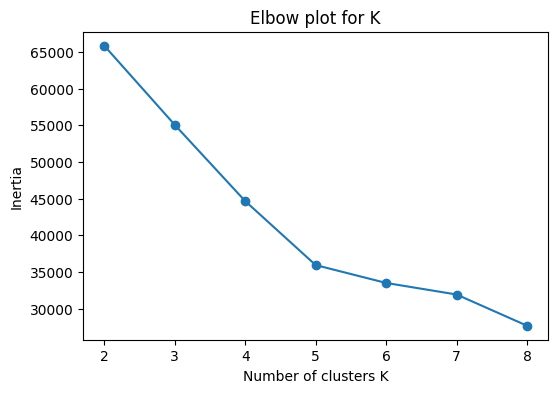

In [6]:
# cell 6
inertia = []
K_range = range(2, 9)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow plot for K')
plt.xlabel('Number of clusters K')
plt.ylabel('Inertia')
plt.show()

In [7]:
# cell 7
k_best = 4
kmeans = KMeans(n_clusters=k_best, random_state=RANDOM_STATE)
clusters = kmeans.fit_predict(X_scaled)

# attach cluster labels
df['cluster'] = clusters
df['cluster'].value_counts()

cluster
1    5657
0    1760
2    1621
3     962
Name: count, dtype: int64

In [8]:
# cell 8
# Get center in original scale: inverse_transform
centers_scaled = kmeans.cluster_centers_
centers = scaler.inverse_transform(centers_scaled)

# Columns of X
feature_names = X.columns

cluster_centers_df = pd.DataFrame(centers, columns=feature_names)
cluster_centers_df

,sales_amount,profit_margin,demographic_Seniors,demographic_Teens,demographic_Young adults,product_DR Pepper Classic,product_DR Pepper Zero Sugar,product_Diet DR Pepper
0,2.968897,0.186035,9.721433e-02,8.925526e-02,4.775441e-01,-2.164935e-15,9.994315e-01,1.665335e-16
1,3.556146,0.186235,1.203818e-01,-2.026157e-15,4.908962e-01,7.108008e-01,1.054712e-15,-8.049117e-16
2,3.518101,0.147742,1.110223e-16,9.993835e-01,1.332268e-15,5.887793e-01,1.602959e-01,2.359224e-16
3,3.198711,0.179594,9.251559e-02,2.151767e-01,3.866944e-01,4.440892e-16,-3.330669e-16,1.000000e+00


In [9]:
# cell 10
# Basic TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=50,  # keep top 50 terms
    token_pattern=r'(?u)\b\w+\b'
)
tfidf_matrix = vectorizer.fit_transform(df['comment'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

tfidf_df.head()

,bought,buy,carbonation,damaged,enjoyed,family,favorite,free,gathering,great,...,okay,packaging,parties,perfect,prefer,satisfied,sugar,sweet,taste,value
0,0.0,0.0,0.0,0.000000,0.707107,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.707107,0.707107,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.707107,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.707107,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.707107,0.0,0.0,0.0,...,0.707107,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.707107,0.0,0.0,0.0,...,0.707107,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# cell 11
df_tfidf = pd.concat([df[['cluster']], tfidf_df], axis=1)

# Average tfidf values per cluster, sort top terms
top_terms_per_cluster = {}
for c in range(k_best):
    avg_tfidf = df_tfidf[df_tfidf['cluster'] == c].drop(columns=['cluster']).mean()
    top_terms = avg_tfidf.sort_values(ascending=False).head(5).index.tolist()
    top_terms_per_cluster[c] = top_terms

top_terms_per_cluster

{0: ['sweet', 'lunch', 'enjoyed', 'carbonation', 'satisfied'],
 1: ['sweet', 'enjoyed', 'lunch', 'parties', 'perfect'],
 2: ['sweet', 'enjoyed', 'lunch', 'parties', 'perfect'],
 3: ['sweet', 'favorite', 'okay', 'carbonation', 'satisfied']}

In [11]:
# cell 12
# Example: use first 5 TF-IDF columns as features
tfidf_subset = tfidf_df.iloc[:, :5]

# Rebuild feature matrix
X_new = pd.concat([numeric, df_onehot, tfidf_subset], axis=1)
X_new_scaled = scaler.fit_transform(X_new)

kmeans_new = KMeans(n_clusters=k_best, random_state=RANDOM_STATE)
clusters_new = kmeans_new.fit_predict(X_new_scaled)

df['cluster_text_aug'] = clusters_new
df['cluster_text_aug'].value_counts()


cluster_text_aug
1    6410
2    1575
3    1173
0     842
Name: count, dtype: int64

In [12]:
# cell 13
# Save full dataset with cluster labels
df.to_csv('dr_pepper_sales_clusters.csv', index=False)
print("Saved dataset with cluster labels.")

Saved dataset with cluster labels.
